In [1]:
# from openai import OpenAI

# client = OpenAI(
#     base_url="https://lzl4i1wx0cdh9a-8000.proxy.runpod.net/v1",
#     api_key=""
# )

# resp = client.chat.completions.create(
#     model="llama4scout",
#     messages=[
#         {"role": "system", "content": "You are a concise assistant."},
#         {"role": "user", "content": "Привет! Что такое LLM? Кратко."}
#     ],
#     temperature=0.2,
# )
# print(resp.choices[0].message.content)

In [2]:
from IPython.display import Image, display

import app.agent as agent

In [3]:
graph = agent.build_agent_with_router()

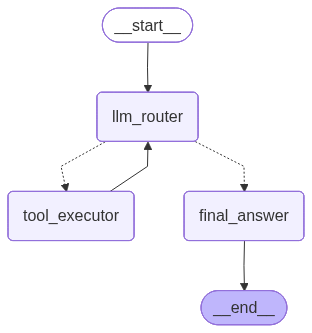

In [4]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
from app.agent import AgentState
from langchain_core.messages import (
    HumanMessage,
)

In [5]:
user_q = "График топ-5 продуктов по продажам в тенге за последние 30 дней"

init_state: AgentState = {
    "messages": [HumanMessage(user_q)],
    "next_tool": None,
    "tool_args": None,
    "final_answer_ready": False,
}
out = graph.invoke(init_state, config={"configurable": {"thread_id": "demo2"}})

 - TOOL CALL: get_current_date()
 - TOOL CALL: list_tables()
 - TOOL CALL: describe_table(fact_sales)
 - TOOL CALL: describe_table(dict_sku)
 - TOOL CALL: execute_query(SELECT s.sku_id, d.sku_name, SUM(s.sales_tg) as total_sales_tg FROM fact_sales s JOIN dict_sku d ON s.sku_id = d.sku_id WHERE s.order_date >= '2025-08-15' AND s.order_date <= '2025-09-14' GROUP BY s.sku_id, d.sku_name ORDER BY total_sales_tg DESC LIMIT 5;)


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_7", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [12]:
user_q = "А какой самый часто продаваемый продукт? Дай названия, не SKU"

init_state: AgentState = {
    "messages": [HumanMessage(user_q)],
    "next_tool": None,
    "tool_args": None,
    "final_answer_ready": False,
}
out = graph.invoke(init_state, config={"configurable": {"thread_id": "demo2"}})

 - TOOL CALL: get_current_date()
 - TOOL CALL: list_tables()
 - TOOL CALL: describe_table(fact_sales)
 - TOOL CALL: describe_table(dict_sku)
 - TOOL CALL: execute_query(SELECT T2.sku_name, SUM(T1.sales_unit) as total_sales FROM fact_sales T1 INNER JOIN dict_sku T2 ON T1.sku_id = T2.sku_id GROUP BY T2.sku_name ORDER BY total_sales DESC LIMIT 1)


In [13]:
print(out['messages'][-1].content)

The best-selling product is **Сахар белый песок (вес)**, with a total sales of **810,107 units**. This product has the highest sales volume among all products.


In [5]:
import app.tools as tools

In [6]:
tools.list_tables()

 - TOOL CALL: list_tables()


['dict_store', 'dict_sku', 'fact_sales', 'metadata']

In [7]:
import os
import pandas as pd
from app.tools import get_db_conn


In [8]:
conn = get_db_conn()
sql = "SELECT s.sku_id, d.sku_name, SUM(s.sales_tg) as total_sales_tg FROM fact_sales s JOIN dict_sku d ON s.sku_id = d.sku_id WHERE s.order_date >= '2025-08-15' GROUP BY s.sku_id, d.sku_name ORDER BY total_sales_tg DESC LIMIT 5"

In [9]:
out_dir = os.getenv("PLOTS_DIR", "data/plots")
plot_type = "bar"
x_col = "sku_name"
y_col = "total_sales_tg"
os.makedirs(out_dir, exist_ok=True)
fname = f"{plot_type}_plot_{x_col}_{y_col}.png"
path = os.path.join(out_dir, fname)

df = pd.read_sql_query(sql, conn)

In [11]:
import matplotlib.pyplot as plt
title = "Топ-5 продуктов по продажам в тенге за последние 30 дней"

plt.figure(figsize=(8,5))
df.plot(kind=plot_type, x=x_col, y=y_col, legend=False, color=plt.cm.Pastel1.colors)

plt.ylabel(y_col)
plt.title(title)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(path)
plt.close()
img_path = os.path.abspath(path)
print(f"Image path: {img_path}")

Image path: /Users/aziz/Documents/repos/shai-hackathon/data/plots/bar_plot_sku_name_total_sales_tg.png


In [6]:
print(out['messages'][-1].content)

В базе данных есть две таблицы: 

- **sku_catalog**: Каталог товаров 
- **sales**: Продажи


In [7]:
import app.tools as tools

In [8]:
tools.list_tables()

 - TOOL CALL: list_tables()


['sku_catalog', 'sales']

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os

In [3]:
os.getenv("DB_NAME", "retail_demo.db")

'data.db'

In [7]:
from app.tools import get_db_conn
import pandas as pd

In [ ]:
conn = get_db_conn()
sql = "SELECT * FROM sales"
df = pd.read_sql_query(sql, conn)

In [10]:
df.head()

,bill_id,date,sku,amount,count
0,bill_1,2025-07-01,SKU_7,1132.0,2
1,bill_2,2025-07-01,SKU_7,1674.0,3
2,bill_3,2025-07-01,SKU_8,199.0,1
3,bill_4,2025-07-01,SKU_8,920.0,4
4,bill_5,2025-07-01,SKU_6,869.0,1


In [5]:
from app.prompts import LLM_ROUTER_PROMPT

print(LLM_ROUTER_PROMPT)


You are a smart data analyst agent. Your job is to choose which tool to use next to gather the required data.
Your goal is to gather ALL necessary data to answer the user's question.
You are working for a retail store and are connected to its SQLite3 database.
Allowed tools:
- get_current_date() -> str:
    Returns the current date in YYYY-MM-DD format.

- list_tables() -> List[str]:
    Returns the names of all tables in the DB.

- describe_table(table_name: str) -> List[tuple[str, str]]:
    For a given table name returns its schema.

- execute_query(sql: str) -> List[list[str]]:
    Executes an SQL query and returns the result.

- give_column_summary(handle_id: str, col_name: str) -> str:
    Returns a summary of the column in a dataframe.
    Args:
        handle_id: The id of the dataframe artifact.
        col_name: The name of the column to summarize.
    Returns:
        A summary of the column.

- make_simple_plot(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str':
  

In [6]:
from app.prompts import format_tools_for_prompt

In [7]:
import app.tools as tools

In [11]:
print(format_tools_for_prompt({"give_column_summary": tools.give_column_summary}))


- give_column_summary(handle_id: str, col_name: str) -> str:
    Returns a summary of the column in a dataframe.
    Args:
        handle_id: The id of the dataframe artifact.
        col_name: The name of the column to summarize.
    Returns:
        A summary of the column.


In [12]:
print(format_tools_for_prompt({"make_simple_plot": tools.make_simple_plot}))

- make_simple_plot(tool_input: 'str', callbacks: 'Callbacks' = None) -> 'str':
    Tool that can operate on any number of inputs.


In [ ]:
def test()